In [ ]:
!pip install diffusers

In [ ]:
!pip install transparent_background

In [ ]:
!pip install accelerate

In [ ]:
from diffusers import DiffusionPipeline


model_id = "yahoo-inc/photo-background-generation"
pipeline = DiffusionPipeline.from_pretrained(model_id, custom_pipeline=model_id)
pipeline = pipeline.to("cuda")

Cannot initialize model with low cpu memory usage because `accelerate` was not found in the environment. Defaulting to `low_cpu_mem_usage=False`. It is strongly recommended to install `accelerate` for faster and less memory-intense model loading. You can do so with: 
```
pip install accelerate
```
.


Fetching 17 files:   0%|          | 0/17 [00:00<?, ?it/s]

text_encoder/config.json:   0%|          | 0.00/723 [00:00<?, ?B/s]

controlnet/config.json:   0%|          | 0.00/1.42k [00:00<?, ?B/s]

tokenizer/merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

tokenizer/added_tokens.json:   0%|          | 0.00/67.0 [00:00<?, ?B/s]

(…)ature_extractor/preprocessor_config.json:   0%|          | 0.00/518 [00:00<?, ?B/s]

scheduler/scheduler_config.json:   0%|          | 0.00/654 [00:00<?, ?B/s]

tokenizer/special_tokens_map.json:   0%|          | 0.00/211 [00:00<?, ?B/s]

tokenizer/tokenizer_config.json:   0%|          | 0.00/973 [00:00<?, ?B/s]

tokenizer/vocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

unet/config.json:   0%|          | 0.00/1.88k [00:00<?, ?B/s]

vae/config.json:   0%|          | 0.00/765 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/1.46G [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.36G [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/3.46G [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/335M [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

In [ ]:
from PIL import Image, ImageOps
import requests
from diffusers.utils import load_image
from transparent_background import Remover


def resize_with_padding(img, expected_size):
    img.thumbnail((expected_size[0], expected_size[1]))
    # print(img.size)
    delta_width = expected_size[0] - img.size[0]
    delta_height = expected_size[1] - img.size[1]
    pad_width = delta_width // 2
    pad_height = delta_height // 2
    padding = (pad_width, pad_height, delta_width - pad_width, delta_height - pad_height)
    return ImageOps.expand(img, padding)

img = Image.open("/content/lamp.jpg")
img = resize_with_padding(img, (512, 512))

# Load background detection model
remover = Remover() # default setting
remover = Remover(mode='base') # nightly release checkpoint

# Get foreground mask
fg_mask = remover.process(img, type='map')

/usr/local/lib/python3.10/dist-packages/torch/functional.py:512: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3587.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


Settings -> Mode=base, Device=cuda:0, Torchscript=disabled
Settings -> Mode=base, Device=cuda:0, Torchscript=disabled


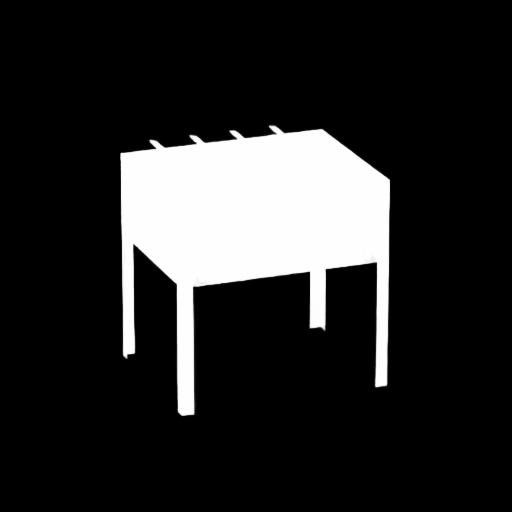

In [ ]:
fg_mask

  0%|          | 0/20 [00:00<?, ?it/s]

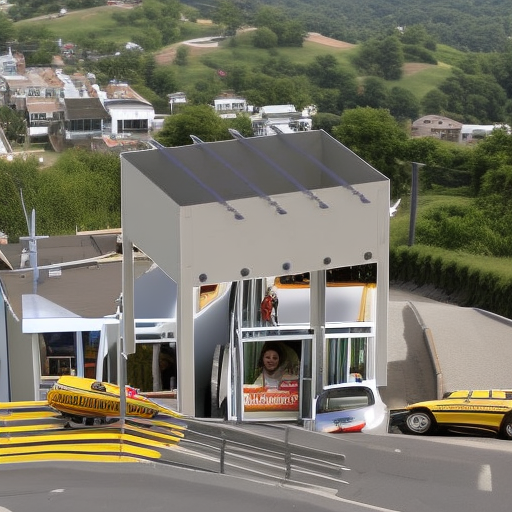

In [ ]:
import torch


seed = 42
mask = ImageOps.invert(fg_mask)
img = resize_with_padding(img, (512, 512))
generator = torch.Generator(device="cuda").manual_seed(seed)
prompt = "a lamp on the table"
negative_prompt = "pedestal"
cond_scale = 1.0
with torch.autocast("cuda"):
    controlnet_image = pipeline(
        prompt=prompt, negative_prompt=negative_prompt, image=img, mask_image=mask, control_image=mask, num_images_per_prompt=1, generator=generator, num_inference_steps=20, guess_mode=False, controlnet_conditioning_scale=cond_scale,
    ).images[0]
controlnet_image

In [ ]:
del pipeline
torch.cuda.empty_cache()

In [ ]:
from diffusers import AutoPipelineForInpainting
from diffusers.utils import load_image
import torch


pipe = AutoPipelineForInpainting.from_pretrained("diffusers/stable-diffusion-xl-1.0-inpainting-0.1", torch_dtype=torch.float16, variant="fp16").to("cuda")

/usr/local/lib/python3.10/dist-packages/diffusers/models/transformers/transformer_2d.py:34: FutureWarning: `Transformer2DModelOutput` is deprecated and will be removed in version 1.0.0. Importing `Transformer2DModelOutput` from `diffusers.models.transformer_2d` is deprecated and this will be removed in a future version. Please use `from diffusers.models.modeling_outputs import Transformer2DModelOutput`, instead.
  deprecate("Transformer2DModelOutput", "1.0.0", deprecation_message)
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.w

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

The config attributes {'decay': 0.9999, 'inv_gamma': 1.0, 'min_decay': 0.0, 'optimization_step': 37000, 'power': 0.6666666666666666, 'update_after_step': 0, 'use_ema_warmup': False} were passed to UNet2DConditionModel, but are not expected and will be ignored. Please verify your config.json configuration file.


In [ ]:
from PIL import Image, ImageOps
import requests
from diffusers.utils import load_image
from transparent_background import Remover


def resize_with_padding(img, expected_size):
    img.thumbnail((expected_size[0], expected_size[1]))
    # print(img.size)
    delta_width = expected_size[0] - img.size[0]
    delta_height = expected_size[1] - img.size[1]
    pad_width = delta_width // 2
    pad_height = delta_height // 2
    padding = (pad_width, pad_height, delta_width - pad_width, delta_height - pad_height)
    return ImageOps.expand(img, padding)

image = Image.open("/content/lamp.jpg")
image = resize_with_padding(image, (1024, 1024))

# Load background detection model
remover = Remover() # default setting
remover = Remover(mode='base') # nightly release checkpoint

# Get foreground mask
fg_mask = remover.process(image, type='map')
mask_image = ImageOps.invert(fg_mask)

Settings -> Mode=base, Device=cuda:0, Torchscript=disabled
Settings -> Mode=base, Device=cuda:0, Torchscript=disabled


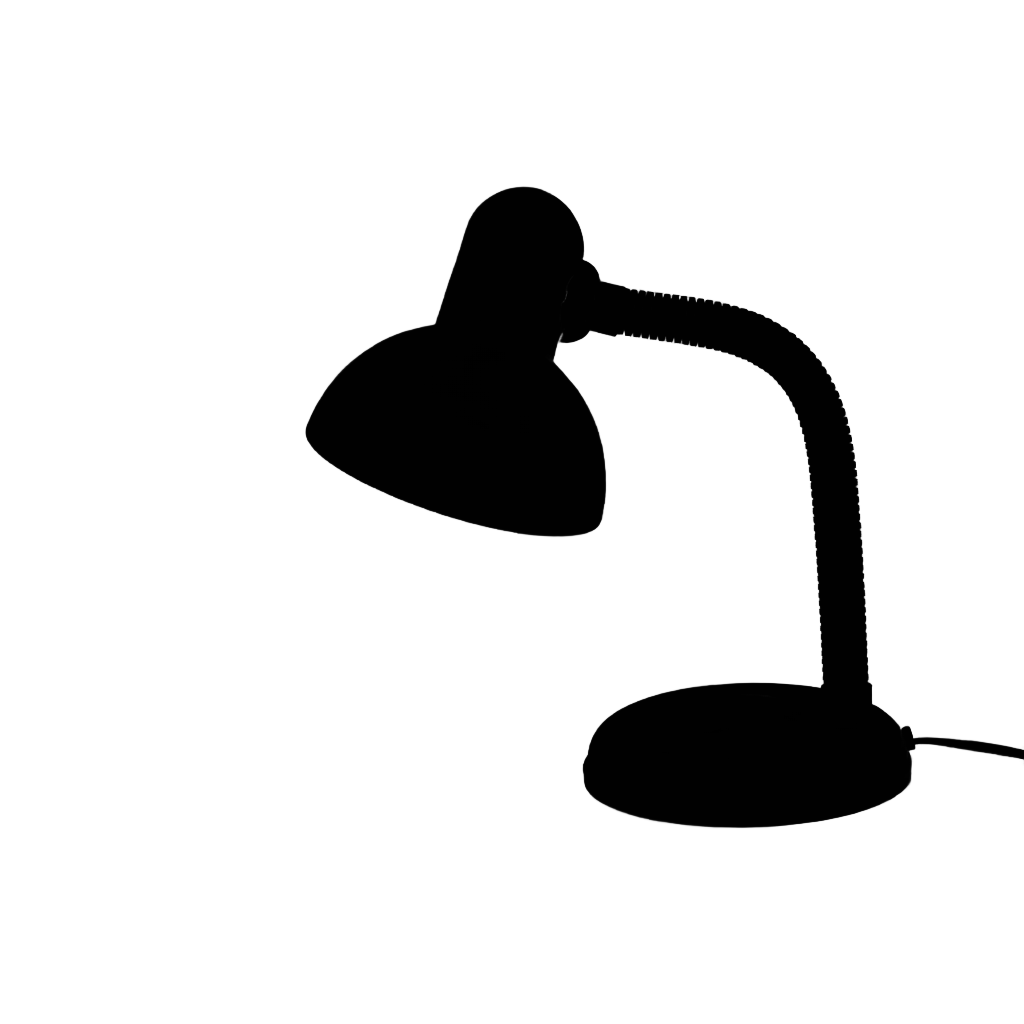

In [ ]:
mask_image

  0%|          | 0/20 [00:00<?, ?it/s]

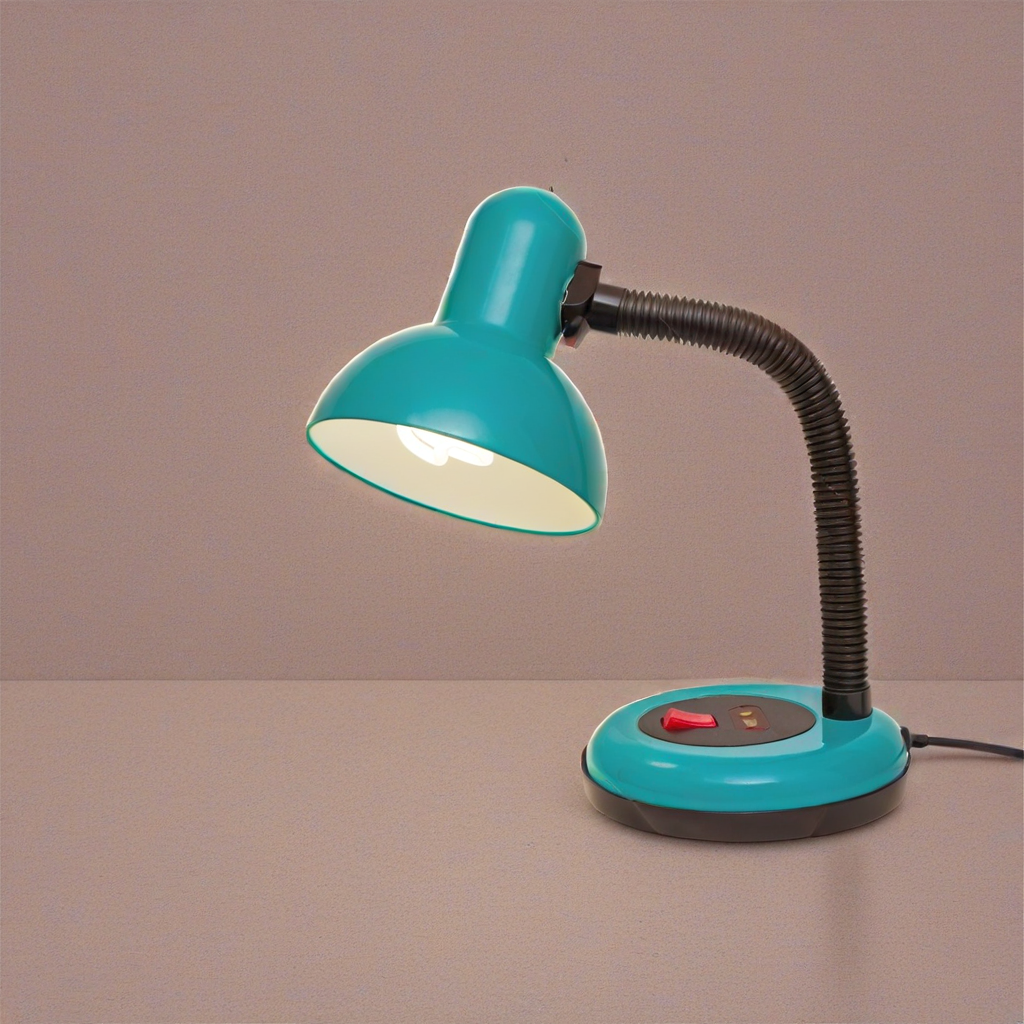

In [ ]:
prompt = "a lamp standing on the table"
generator = torch.Generator(device="cuda").manual_seed(42)

pipe(
  prompt=prompt,
  image=image,
  mask_image=mask_image,
  guidance_scale=12.0,
  num_inference_steps=20,  # steps between 15 and 30 work well for us
  strength=1.0,  # make sure to use `strength` below 1.0
  generator=generator,
).images[0]

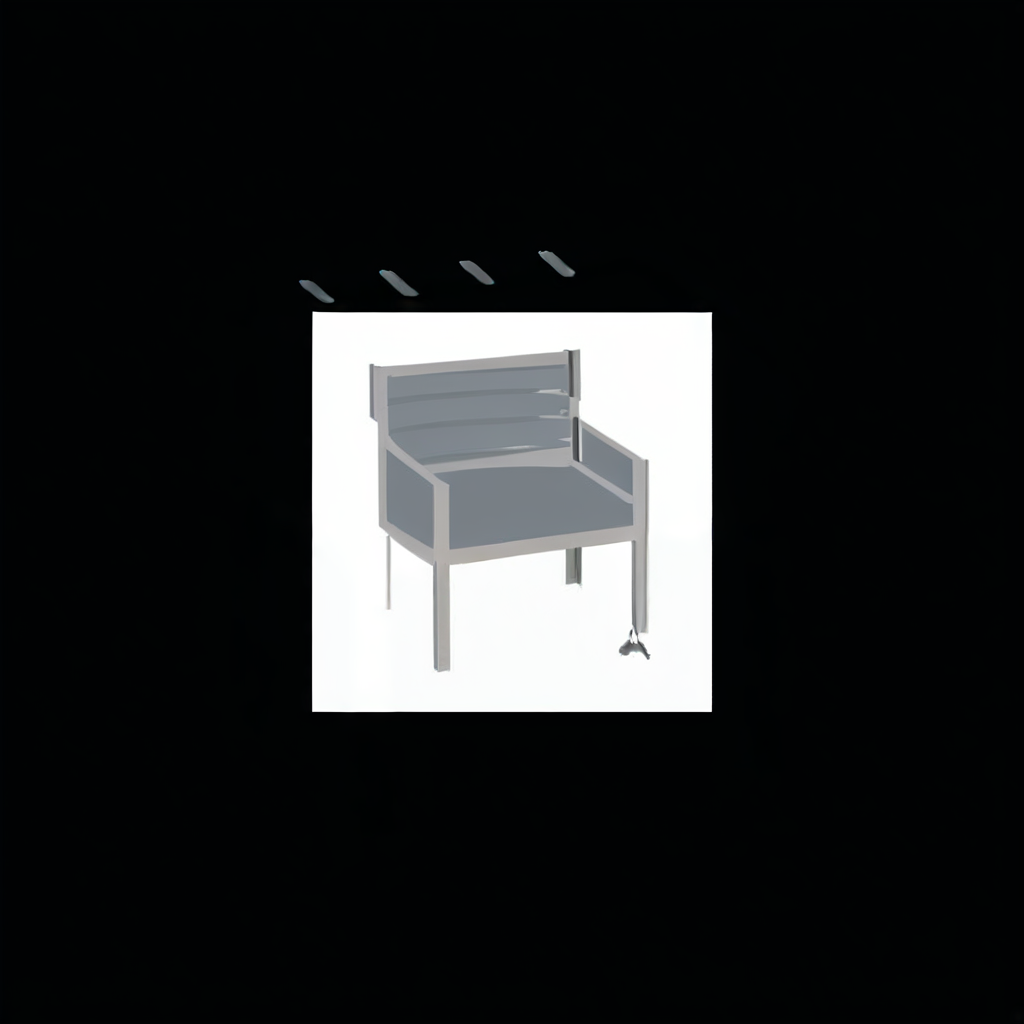

In [ ]:
image